# <center>Convolution Neural Networks</center>
<center>
        Shan-Hung Wu & DataLab
        <br>
        Fall 2022
</center>

In this lab, we introduce two datasets, **MNIST** and **CIFAR**, then we will talk about how to implement CNN models for these two datasets using tensorflow. The major difference between mnist and cifar is their size. Due to the limit of memory size and time issue, we offer a guide to illustrate typical **input pipeline** of tensorflow. Let's dive into tensorflow!

In [ ]:
import warnings
import os
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
import matplotlib.pyplot as plt
import numpy as np

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[2], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

4 Physical GPUs, 1 Logical GPUs


## MNIST

We start from a simple dataset. MNIST is a simple computer vision dataset. It consists of images of handwritten digits like:

<center><img style='width: 30%' src='imgsrc/MNIST.png' /></center>

It also includes labels for each image, telling us which digit it is. For example, the labels for the above images are 5, 0, 4, and 1. Each image is 28 pixels by 28 pixels. We can interpret this as a big array of numbers:

<center><img style='width: 30%' src='imgsrc/MNIST2.png' /></center>

The MNIST data is hosted on [Yann LeCun's website](http://yann.lecun.com/exdb/mnist/). We can directly import MNIST dataset from Tensorflow. 

In [3]:
# Download and prepare the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = datasets.mnist.load_data()

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0
print('shape of train_images:', train_images.shape)
print('shape of train_labels:', train_labels.shape)

shape of train_images: (60000, 28, 28)
shape of train_labels: (60000,)


### Softmax Regression on MNIST

Before jumping to *Convolutional Neural Network* model, we're going to start with a very simple model with a single layer and softmax regression.

We know that every image in MNIST is a handwritten digit between zero and nine. So there are only ten possible digits that a given image can be. We want to give the probability of the input image for being each digit. That is, input an image, the model outputs a ten-dimension vector.

This is a classic case where a softmax regression is a natural, simple model. If you want to assign probabilities to an object being one of several different things, softmax is the thing to do.

In [4]:
# flating the training data for dense layers
train_images_1 = train_images.reshape((60000, -1))
test_images_1 = test_images.reshape((10000, -1))
print(train_images_1.shape)
print(test_images_1.shape)

(60000, 784)
(10000, 784)


In [5]:
model_1 = models.Sequential()
model_1.add(layers.Dense(10, activation='softmax',input_shape=(784,)))
model_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [6]:
# compile the model and train it for 5 epochs
model_1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_1.fit(train_images_1, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.4760 - accuracy: 0.8762
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3044 - accuracy: 0.9157
Epoch 3/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2839 - accuracy: 0.9216
Epoch 4/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2733 - accuracy: 0.9240
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2671 - accuracy: 0.9251


In [7]:
_, test_acc_1 = model_1.evaluate(test_images_1, test_labels, verbose=0)
print('Testing Accuracy : %.4f'%test_acc_1)

Testing Accuracy : 0.9247


From the above result, we got about 92.4% accuracy for *Softmax Regression* on MNIST. In fact, it's not so good. This is because we're using a very simple model.

### Multilayer Convolutional Network on MNIST

We're now jumping from a very simple model to something moderately sophisticated: a small *Convolutional Neural Network*. This will get us to over 99% accuracy, not state of the art, but respectable.

In [8]:
# reshaping the training data to 3 dimensions
train_images_2 = train_images.reshape((60000, 28, 28, 1))
test_images_2 = test_images.reshape((10000, 28, 28, 1))
print(train_images_2.shape)
print(test_images_2.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


#### Create the convolutional base
As input, a CNN takes tensors of shape (image_height, image_width, color_channels), ignoring the batch size. If you are new to color channels, MNIST has one (because the images are grayscale), whereas a color image has three (R,G,B). In this example, we will configure our CNN to process inputs of shape (28, 28, 1), which is the format of MNIST images. We do this by passing the argument **input_shape** to our first layer.

In [9]:
#The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.
model_2 = models.Sequential()
model_2.add(layers.Conv2D(32, (3, 3), strides=(1,1), padding='valid', activation='relu', input_shape=(28, 28, 1)))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='valid', activation='relu'))
model_2.add(layers.MaxPooling2D((2, 2)))
model_2.add(layers.Conv2D(64, (3, 3), strides=(1,1), padding='valid', activation='relu'))

Let's display the architecture of our model so far.

In [10]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
Total params: 55,744
Trainable params: 55,744
Non-trai

Above, you can see that the output of every Conv2D and MaxPooling2D layer is a 3D tensor of shape (height, width, channels). The width and height dimensions tend to shrink as we go deeper in the network. The number of output channels for each Conv2D layer is controlled by the first argument (e.g., 32 or 64). Typically, as the width and height shrink, we can afford (computationally) to add more output channels in each Conv2D layer.

#### Add Dense layers on top
To complete our model, we will feed the last output tensor from the convolutional base (of shape (3, 3, 64)) into one or more Dense layers to perform classification. Dense layers take vectors as input (which are 1D), while the current output is a 3D tensor. First, we will flatten (or unroll) the 3D output to 1D, then add one or more Dense layers on top. MNIST has 10 output classes, so we use a final Dense layer with 10 outputs and a softmax activation.

To reduce overfitting, we will apply [*dropout*](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf) before the readout layer. The idea behind dropout is to train an ensemble of model instead of a single model. During training, we drop out neurons with probability $p$, i.e., the probability to keep is $1-p$. When a neuron is dropped, its output is set to zero. These dropped neurons do not contribute to the training phase in forward pass and backward pass. For each training phase, we train the network slightly different from the previous one. It's just like we train different networks in each training phrase. However, during testing phase, we **don't** drop any neuron, and thus, implement dropout is kind of like doing ensemble. Also, randomly drop units in training phase can prevent units from co-adapting too much. Thus, dropout is a powerful regularization techique to deal with *overfitting*. 

In [11]:
model_2.add(layers.Flatten())
model_2.add(layers.Dense(64, activation='relu'))
model_2.add(layers.Dropout(0.5))
model_2.add(layers.Dense(10, activation='softmax'))

Here's the complete architecture of our model.

In [12]:
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten (Flatten)           (None, 576)              

As you can see, our (3, 3, 64) outputs were flattened into vectors of shape (576) before going through two Dense layers.

#### Compile and train the model

In [13]:
model_2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_2.fit(train_images_2, train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 13s 6ms/step - loss: 0.2574 - accuracy: 0.9211
Epoch 2/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0870 - accuracy: 0.9754
Epoch 3/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0650 - accuracy: 0.9827
Epoch 4/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0492 - accuracy: 0.9863
Epoch 5/5
1875/1875 [==============================] - 11s 6ms/step - loss: 0.0411 - accuracy: 0.9880


In [14]:
_, test_acc_2 = model_2.evaluate(test_images_2, test_labels, verbose=0)
print('Testing Accuracy : %.4f'%test_acc_2)

Testing Accuracy : 0.9902


As you can see, our simple CNN has achieved a test accuracy of 99%. Not bad for a few lines of code! For another style of writing a CNN (using the Keras Subclassing API and a GradientTape) head [here](https://www.tensorflow.org/tutorials/quickstart/advanced).

## Cifar-10

Actually MNIST is a easy dataset for the beginner. To demonstrate the power of *Neural Networks*, we need a larger dataset *CIFAR-10*.

[CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60000 32x32 color images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. Here are the classes in the dataset, as well as 10 random images from each:

<center><img style='width: 40%' src='imgsrc/CIFAR10.png' /></center>

Before jumping to a complicated neural network model, we're going to start with **KNN** and **SVM**. The motivation here is to compare neural network model with traditional classifiers, and highlight the performance of neural network model.  

tf.keras.datasets offers convenient facilities that automatically access some well-known datasets. Let's load the CIFAR-10 in tf.keras.datasets:

In [15]:
# Loading Data
import math

(X_train, y_train), (X_test, y_test) = datasets.cifar10.load_data()

# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# convert class vectors to binary vectors
Y_train = utils.to_categorical(y_train)
Y_test = utils.to_categorical(y_test)

print('X_train shape:', X_train.shape)
print('Y_train shape:', Y_train.shape)
print('X_test shape:', X_test.shape)
print('Y_test shape:', Y_test.shape)

X_train shape: (50000, 32, 32, 3)
Y_train shape: (50000, 10)
X_test shape: (10000, 32, 32, 3)
Y_test shape: (10000, 10)


For simplicity, we also convert the images into the grayscale. We use the [Luma coding](https://en.wikipedia.org/wiki/Grayscale#Luma_coding_in_video_systems) that is common in video systems:

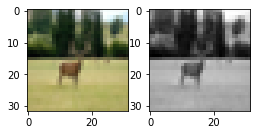

In [16]:
# transform a 3-channel image into one channel
def grayscale(data, dtype='float32'):
    # luma coding weighted average in video systems
    r = np.asarray(.3, dtype=dtype)
    g = np.asarray(.59, dtype=dtype)
    b = np.asarray(.11, dtype=dtype)
    rst = r * data[:, :, :, 0] + g * data[:, :, :, 1] + b * data[:, :, :, 2]
    # add channel dimension
    rst = np.expand_dims(rst, axis=3)
    return rst

X_train_gray = grayscale(X_train)
X_test_gray = grayscale(X_test)

# plot a randomly chosen image
img = round(np.random.rand() * X_train.shape[0])
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(X_train[img], interpolation='none')
plt.subplot(1, 2, 2)
plt.imshow(
    X_train_gray[img, :, :, 0], cmap=plt.get_cmap('gray'), interpolation='none')
plt.show()

As we can see, the objects in grayscale images can still be recognizable.

#### Feature Selection
When coming to object detection, HOG (histogram of oriented gradients) is often extracted as a feature for classification. It first calculates the gradients of each image patch using sobel filter, then use the magnitudes and orientations of derived gradients to form a histogram per patch (a vector). After normalizing these histograms, it concatenates them into one HOG feature. For more details, read this [tutorial](https://www.learnopencv.com/histogram-of-oriented-gradients/). 
>Note.  one can directly feed the original images for classification; however, it will take lots of time to train and get worse performance.

In [17]:
def getHOGfeat(image,
               stride=8,
               orientations=8,
               pixels_per_cell=(8, 8),
               cells_per_block=(2, 2)):
    cx, cy = pixels_per_cell
    bx, by = cells_per_block
    sx, sy, sz = image.shape
    n_cellsx = int(np.floor(sx // cx))  # number of cells in x
    n_cellsy = int(np.floor(sy // cy))  # number of cells in y
    n_blocksx = (n_cellsx - bx) + 1
    n_blocksy = (n_cellsy - by) + 1
    gx = np.zeros((sx, sy), dtype=np.double)
    gy = np.zeros((sx, sy), dtype=np.double)
    eps = 1e-5
    grad = np.zeros((sx, sy, 2), dtype=np.double)
    for i in range(1, sx - 1):
        for j in range(1, sy - 1):
            gx[i, j] = image[i, j - 1] - image[i, j + 1]
            gy[i, j] = image[i + 1, j] - image[i - 1, j]
            grad[i, j, 0] = np.arctan(gy[i, j] / (gx[i, j] + eps)) * 180 / math.pi
            if gx[i, j] < 0:
                grad[i, j, 0] += 180
            grad[i, j, 0] = (grad[i, j, 0] + 360) % 360
            grad[i, j, 1] = np.sqrt(gy[i, j] ** 2 + gx[i, j] ** 2)
    normalised_blocks = np.zeros((n_blocksy, n_blocksx, by * bx * orientations))
    for y in range(n_blocksy):
        for x in range(n_blocksx):
            block = grad[y * stride:y * stride + 16, x * stride:x * stride + 16]
            hist_block = np.zeros(32, dtype=np.double)
            eps = 1e-5
            for k in range(by):
                for m in range(bx):
                    cell = block[k * 8:(k + 1) * 8, m * 8:(m + 1) * 8]
                    hist_cell = np.zeros(8, dtype=np.double)
                    for i in range(cy):
                        for j in range(cx):
                            n = int(cell[i, j, 0] / 45)
                            hist_cell[n] += cell[i, j, 1]
                    hist_block[(k * bx + m) * orientations:(k * bx + m + 1) * orientations] = hist_cell[:]
            normalised_blocks[y, x, :] = hist_block / np.sqrt(
                hist_block.sum() ** 2 + eps)
    return normalised_blocks.ravel()

Once we have our *getHOGfeat* function, we then get the HOG features of all images.

In [18]:
X_train_hog = []
X_test_hog = []

print('This will take some minutes.')

for img in X_train_gray:
    img_hog = getHOGfeat(img)
    X_train_hog.append(img_hog)

for img in X_test_gray:
    img_hog = getHOGfeat(img)
    X_test_hog.append(img_hog)

X_train_hog_array = np.asarray(X_train_hog)
X_test_hog_array = np.asarray(X_test_hog)

This will take some minutes.


### K Nearest Neighbors (KNN) on CIFAR-10

[scikit-learn](http://scikit-learn.org/stable/supervised_learning.html#supervised-learning) provides off-the-shelf libraries for classification. For KNN and SVM classifiers, we can just import from scikit-learn to use.

In [19]:
# KNN
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.metrics import accuracy_score

# p=2 and metric='minkowski' means the Euclidean Distance
knn = KNeighborsClassifier(n_neighbors=11, p=2, metric='minkowski')

knn.fit(X_train_hog_array, y_train.ravel())
y_pred = knn.predict(X_test_hog_array)
print('[KNN]')
print('Misclassified samples: %d' % (y_test.ravel() != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test, y_pred))

[KNN]
Misclassified samples: 5334
Accuracy: 0.47


We can observe that the accuracy of KNN on CIFAR-10 is embarrassingly bad.

### Support Vector Machine (SVM) on CIFAR-10

In [20]:
# SVM
from sklearn.svm import SVC 

# C is the hyperparameter for the error penalty term
# gamma is the hyperparameter for the rbf kernel
svm_linear = SVC(kernel='linear', random_state=0, gamma=0.2, C=10.0)

svm_linear.fit(X_train_hog_array, y_train.ravel())
y_pred = svm_linear.predict(X_test_hog_array)
print('[Linear SVC]')
print('Misclassified samples: %d' % (y_test.ravel() != y_pred).sum())
print('Accuracy: %.2f' % accuracy_score(y_test.ravel(), y_pred))

[Linear SVC]
Misclassified samples: 4940
Accuracy: 0.51


### CNN on CIFAR-10
By above, SVM is slightly better than KNN, but still poor. Next, we'll design a CNN model using tensorflow.

In [21]:
#The 6 lines of code below define the convolutional base using a common pattern: a stack of Conv2D and MaxPooling2D layers.
model_3 = models.Sequential()
model_3.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(32, 32, 3)))
model_3.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_3.add(layers.BatchNormalization())
                
model_3.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model_3.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_3.add(layers.BatchNormalization())
                
model_3.add(layers.Flatten())
model_3.add(layers.Dense(384, activation='relu'))
model_3.add(layers.Dropout(0.5))
model_3.add(layers.Dense(192, activation='relu'))
model_3.add(layers.Dense(10, activation='softmax'))
model_3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model_3.fit(X_train, y_train, epochs=200,validation_data=(X_test, y_test),verbose=0)

In [22]:
_, test_acc_3 = model_3.evaluate(X_test, y_test, verbose=0)
print('Testing Accuracy : %.4f'%test_acc_3)

Testing Accuracy : 0.7732


Although Cifar10 is larger than Mnist, it's not large enough for the dataset you will meet in the following lessons. For large datasets, we can't feed all training data to the model due to the limit of memory size. Even if we can feed all data into the model, we still want the process of loading data is efficient. **Input pipeline** is the common way to solve these.

## Input Pipeline

### Structure of an input pipeline
A typical TensorFlow training input pipeline can be framed as an ETL process:

1. Extract: Read data from memory (NumPy) or persistent storage -- either local (HDD or SSD) or remote (e.g. GCS or HDFS).
2. Transform: Use CPU to parse and perform preprocessing operations on the data such as shuffling, batching, and domain specific transformations such as image decompression and augmentation, text vectorization, or video temporal sampling.
3. Load: Load the transformed data onto the accelerator device(s) (e.g. GPU(s) or TPU(s)) that execute the machine learning model.

This pattern effectively utilizes the CPU, while reserving the accelerator for the heavy lifting of training your model. In addition, viewing input pipelines as an ETL process provides a framework that facilitates the application of performance optimizations.
###  tf.data API

To build a data input pipeline with **tf.data**, here are the steps that you can follow:
1. Define data source and initialize your Dataset object
2. Apply transformations on the dataset, following are some common useful techniques
    - map
    - shuffle
    - batch
    - repeat
    - prefetch
3. Create iterator 

#### Construct your Dataset 
To create an input pipeline, you must start with a data source. For example, to construct a **Dataset** from data in memory, you can use [tf.data.Dataset.from_tensors()](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset#from_tensors) or [tf.data.Dataset.from_tensor_slices()](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset#from_tensor_slices). Alternatively, if your input data is stored in a file in the recommended TFRecord format, you can use [tf.data.TFRecordDataset()](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/TFRecordDataset).

Once you have a **Dataset** object, you can *transform* it into a new **Dataset** by
chaining method calls on the **tf.data.Dataset** object. For example, you can
apply per-element transformations such as **Dataset.map()**, and multi-element
transformations such as **Dataset.batch()**. See the documentation for
[tf.data.Dataset](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/data/Dataset#methods) for a complete list of transformations.

Now suppose we have simple data sources:

In [23]:
# number of samples
n_samples = 200

# an array with shape (n_samples, 5)
raw_data_a = np.random.rand(n_samples, 5)
# a list with length of n_samples from 0 to n_samples-1
raw_data_b = np.arange(n_samples)

We can create our tensorflow Dataset object with these two data using **tf.data.Dataset.from_tensor_slices**, which will automatically cut your data into slices:

In [24]:
# this tells the dataset that each row of raw_data_a is corresponding to each element of raw_data_b
raw_dataset = tf.data.Dataset.from_tensor_slices((raw_data_a, raw_data_b))
print(raw_dataset)

<TensorSliceDataset element_spec=(TensorSpec(shape=(5,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


#### Apply transformations
Next, according to your needs, you can preprocess your data in this step.

##### map
For example, **Dataset.map()** provide element-wise customized data preprocessing.


In [25]:
def preprocess_function(one_row_a, one_b):
    """
        Input: one slice of the dataset
        Output: modified slice
    """
    # Do some data preprocessing, you can also input filenames and load data in here
    # Here, we transform each row of raw_data_a to its sum and mean
    one_row_a = [tf.reduce_sum(one_row_a), tf.reduce_mean(one_row_a)]

    return one_row_a, one_b

In [26]:
raw_dataset = raw_dataset.map(preprocess_function, num_parallel_calls=tf.data.experimental.AUTOTUNE)
print(raw_dataset)

<ParallelMapDataset element_spec=(TensorSpec(shape=(2,), dtype=tf.float64, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>


##### shuffle
**Dataset.shuffle(buffer_size)** maintains a fixed-size buffer and chooses the next element uniformly at random from that buffer. This way, you can see your data coming with different order in different epoch. This can prevent your model overfit on the order of your training data.

In [27]:
dataset = raw_dataset.shuffle(16)

##### batch
Now our dataset is one example by one example. However, in reality, we usually want to read one batch at a time, thus we can call **Dataset.batch(batch_size)** to stack batch_size elements together.

<b>Note:</b> Be careful that if you apply **Dataset.shuffle** after **Dataset.batch**, you'll get shuffled batch but data in a batch remains the same.

In [28]:
dataset = dataset.batch(2,drop_remainder=False)

##### repeat
Repeats this dataset count times.

**Dataset.repeat(count)** allow you iterate over a dataset in multiple epochs. **count = None or -1** will let the dataset repeats indefinitely.

In [29]:
dataset = dataset.repeat(2)

If you would like to perform a custom computation (e.g. to collect statistics) at the end of each epoch then it's simplest to restart the dataset iteration on each epoch:

In [30]:
epochs = 3
cus_dataset = raw_dataset.batch(32)

for epoch in range(epochs):
    size = 0
    for batch in cus_dataset:
        size += 1
    print("End of epoch: %d, Batch size of this epoch: %d"%(epoch, size))

End of epoch: 0, Batch size of this epoch: 7
End of epoch: 1, Batch size of this epoch: 7
End of epoch: 2, Batch size of this epoch: 7


##### prefetch
Creates a Dataset that prefetches elements from this dataset.

**Dataset.prefetch(buffer_size)** allow you decouple the time when data is produced from the time when data is consumed.

In [31]:
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

#### Consume elements
The **Dataset** object is a Python iterable. This makes it possible to consume its elements using a for loop:

In [32]:
# Here, we print the first 8 batches.
for i,elem in enumerate(dataset):
    print("Batch ", i, ", b are ", elem[1].numpy())
    if i==8:
        break

Batch  0 , b are  [13 16]
Batch  1 , b are  [0 6]
Batch  2 , b are  [19  9]
Batch  3 , b are  [3 7]
Batch  4 , b are  [23 14]
Batch  5 , b are  [ 4 11]
Batch  6 , b are  [21 28]
Batch  7 , b are  [25  8]
Batch  8 , b are  [2 1]


Or by explicitly creating a Python iterator using **iter** and consuming its
elements using **next**:

In [33]:
# Here, we print the first 8 batches.
it = iter(dataset)
for i in range(8):
    print("Batch ", i, ", b are ", next(it)[1].numpy())

Batch  0 , b are  [1 5]
Batch  1 , b are  [2 9]
Batch  2 , b are  [ 4 17]
Batch  3 , b are  [ 8 11]
Batch  4 , b are  [15 10]
Batch  5 , b are  [ 7 20]
Batch  6 , b are  [27 26]
Batch  7 , b are  [25  3]


#### repeat+batch / batch+repeat 

The Dataset.repeat transformation concatenates its arguments without signaling the end of one epoch and the beginning of the next epoch. Because of this a Dataset.batch applied after Dataset.repeat will yield batches that stradle epoch boundaries:

In [34]:
# use this function to plot the size of each batch.
def plot_batch_sizes(ds,title):
    batch_sizes = [batch[1].shape[0] for batch in ds]
    plt.bar(range(len(batch_sizes)), batch_sizes)
    plt.xlabel('Batch number')
    plt.ylabel('Batch size')
    plt.title(title)
    plt.show()

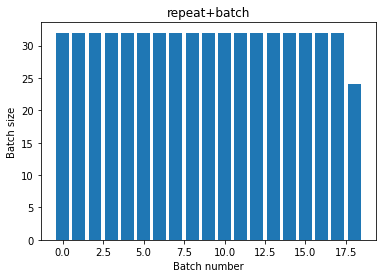

In [35]:
# plot the bar diagram of repeat+batch
repeat_batch_ds = raw_dataset.repeat(3).batch(32)
plot_batch_sizes(repeat_batch_ds,'repeat+batch')

If you need clear epoch separation, put Dataset.batch before the repeat:

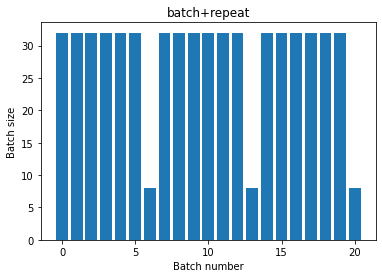

In [36]:
# plot the bar diagram of batch+repeat
batch_repeat_ds = raw_dataset.batch(32).repeat(3)
plot_batch_sizes(batch_repeat_ds,'batch+repeat')

#### shufflt+repeat  / repeat+shufflt
As with Dataset.batch the order relative to Dataset.repeat matters.

Dataset.shuffle doesn't signal the end of an epoch until the shuffle buffer is empty. So a shuffle placed before a repeat will show every element of one epoch before moving to the next.

But a repeat before a shuffle mixes the epoch boundaries together.

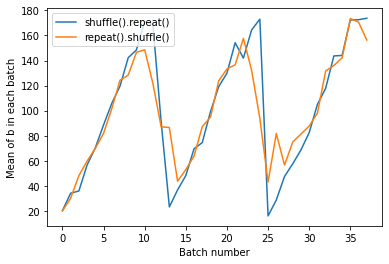

In [37]:
# You can find that a repeat before a shuffle mixes the epoch boundaries in this graph.
shuffle_repeat_ds = raw_dataset.shuffle(32).repeat(3).batch(16)
repeat_shuffle_ds = raw_dataset.repeat(3).shuffle(32).batch(16)

shuffle_repeat = [batch[1].numpy().mean() for batch in shuffle_repeat_ds]
repeat_shuffle = [batch[1].numpy().mean() for batch in repeat_shuffle_ds]

plt.plot(shuffle_repeat, label="shuffle().repeat()")
plt.plot(repeat_shuffle, label="repeat().shuffle()")
plt.xlabel('Batch number')
plt.ylabel("Mean of b in each batch")
plt.legend()

Now, let's start designing our cnn model!

## CNN Model for CIFAR 10

#### Loading Data Manually

To know how it works under the hood, let's load CIFAR-10 by our own (not using tf.keras). According the descripion, the dataset file is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class.

In [38]:
import pickle

# the url to download CIFAR-10 dataset (binary version)
# see format and details here: http://www.cs.toronto.edu/~kriz/cifar.html
DATA_URL = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
# the image size we want to keep
IMAGE_SIZE_CROPPED = 24
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
IMAGE_DEPTH = 3

In [39]:
# donwnload data
if not os.path.exists("cifar-10-batches-py/"): 
    cifar10 = utils.get_file('cifar-10-python.tar.gz',
                                      cache_subdir=os.path.abspath('.'),
                                      origin = DATA_URL,
                                      extract = True)

In [40]:
DEST_DIRECTORY = 'cifar-10-batches-py'
filenames_train = [os.path.join(DEST_DIRECTORY,'data_batch_%d' % i) for i in range(1,6)]
filenames_test = [os.path.join(DEST_DIRECTORY,'test_batch')]

In [42]:
import csv

# save (img_path, label) pairs
with open('cifar10_train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['filenames'])
    writer.writerows(np.array(filenames_train).reshape(-1,1))
        
with open('cifar10_test.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['filenames'])
    writer.writerows(np.array(filenames_test).reshape(-1,1))

In [43]:
# read data
def unpickle(file):
    with open(file, 'rb') as fo:
        raw_data = pickle.load(fo, encoding='bytes')
    return raw_data[b'data'],raw_data[b'labels']

# parse training data
def map_fun(image,label):
    image = tf.reshape(image,[IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1,2,0]),tf.float32),255.0)
    label = tf.one_hot(label,10)
    distorted_image = tf.image.random_crop(image, [IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(
        distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    return distorted_image, label

# parse testing data
def map_fun_test(image,label):
    image = tf.reshape(image,[IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[1,2,0]),tf.float32),255.0)
    label = tf.one_hot(label,10)
    distorted_image = tf.image.resize_with_crop_or_pad(image, IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    return distorted_image, label

In [44]:
X_train = None
Y_train = None
X_test = None
Y_test = None

for filename in filenames_train:
    images,labels = unpickle(filename)
    X_train = images if X_train is None else np.concatenate((X_train,images))
    Y_train = labels if Y_train is None else np.concatenate((Y_train,labels))

for filename in filenames_test:
    images,labels = unpickle(filename)
    X_test = images if X_test is None else np.concatenate((X_test,images))
    Y_test = labels if Y_test is None else np.concatenate((Y_test,labels))

# Construct training Dataset
dataset = tf.data.Dataset.from_tensor_slices((X_train,Y_train))
dataset = dataset.map(map_fun)
dataset = dataset.shuffle(10000)
dataset = dataset.batch(64)

# # Construct testing Dataset
dataset_test = tf.data.Dataset.from_tensor_slices((X_test,Y_test))
dataset_test = dataset_test.map(map_fun_test)
dataset_test = dataset_test.batch(64)

In [45]:
model_cifar = models.Sequential()

model_cifar.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(24, 24, 3)))
model_cifar.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_cifar.add(layers.BatchNormalization())
                
model_cifar.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model_cifar.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_cifar.add(layers.BatchNormalization())
                
model_cifar.add(layers.Flatten())
model_cifar.add(layers.Dense(384, activation='relu'))
model_cifar.add(layers.Dropout(0.5))
model_cifar.add(layers.Dense(192, activation='relu'))
model_cifar.add(layers.Dropout(0.5))
model_cifar.add(layers.Dense(10, activation='softmax'))

In [46]:
model_cifar.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model_cifar.fit(dataset, epochs=200, validation_data=dataset_test, verbose=0)

We have done our training! Let's see whether our model is great or not.

In [47]:
_, test_acc = model_cifar.evaluate(dataset_test, verbose=0)
print('test accuracy:',test_acc)

test accuracy: 0.8391000032424927


## Optimization for input pipeline

We all know that GPUs can radically reduce the time required to execute a single training step; however, all other affairs (including data loading, data transformations, memory copy from CPU to GPUs) are done by CPU, which sometimes becomes the bottleneck instead. We have learned above that there are lots transformations that make datasets more complex and reusable. Now, we are going to accelerate the input pipeline for better training performance, following this [guide](https://www.tensorflow.org/guide/data_performance).

The code below do the same thing in [CNN Model for CIFAR 10](#CNN-Model-for-CIFAR-10). However, we change the dataset structure to show the time comsuming during the training.

In [48]:
import warnings
import os
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pickle
import csv
import itertools
from collections import defaultdict
import time
import pandas as pd
import math
from tqdm import tqdm

In [49]:
# construct a new dataset with time informantion
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string),
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32),
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32),
        tf.TensorSpec(shape=(3072), dtype=tf.float32), # 32*32*3
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )


    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        
        rows = pd.read_csv(filename.decode("utf-8"))
        filenames = rows['filenames']
        open_elapsed = time.perf_counter() - open_enter
        

        sample_idx = 0
        for filename in filenames:
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            imgs, labels = unpickle(filename)
            read_elapsed = time.perf_counter() - read_enter
#             print(imgs.shape)
            
            for i in range(len(imgs)):
#                 print(imgs[i].shape, sample_idx)
                yield (
                    [("Open",), ("Read",)],
                    [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                    [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                    imgs[i],
                    labels[i]
                )
                sample_idx = sample_idx + 1
                read_enter, read_elapsed = -1., -1.
                open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [50]:
IMAGE_SIZE_CROPPED = 24
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
IMAGE_DEPTH = 3

# feel free to modify these two Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# read data
def unpickle(file):
    with open(file, 'rb') as fo:
        raw_data = pickle.load(fo, encoding='bytes')
    return raw_data[b'data'],raw_data[b'labels']

# parse training data
@tf.function
def map_fun(steps, times, values, image, label):
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[tf.shape(image)[0], IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    distorted_image = tf.image.random_crop(image, [tf.shape(image)[0], IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

# parse testing data
def map_fun_test(steps, times, values, image, label):
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[tf.shape(image)[0],IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    distorted_image = tf.image.random_crop(image, [tf.shape(image)[0], IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter
    
    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

In [51]:
def dataset_generator_fun_train(*args):
    return TimeMeasuredDataset('cifar10_train.csv')

def dataset_generator_fun_test(*args):
    return TimeMeasuredDataset('cifar10_test.csv')


dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train)\
                                        .shuffle(BUFFER_SIZE)\
                                        .batch(BATCH_SIZE, drop_remainder=True)\
                                        .map(map_fun)

dataset_test = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_test)\
                                       .batch(BATCH_SIZE, drop_remainder=True)\
                                       .map(map_fun_test)

In [52]:
# re-construct a same model
model_cifar_op = models.Sequential()

model_cifar_op.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu', input_shape=(24, 24, 3)))
model_cifar_op.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_cifar_op.add(layers.BatchNormalization())
                
model_cifar_op.add(layers.Conv2D(64, (5, 5), padding='same', activation='relu'))
model_cifar_op.add(layers.MaxPool2D(pool_size=3,strides=2,padding='same'))
model_cifar_op.add(layers.BatchNormalization())
                
model_cifar_op.add(layers.Flatten())
model_cifar_op.add(layers.Dense(384, activation='relu'))
model_cifar_op.add(layers.Dropout(0.5))
model_cifar_op.add(layers.Dense(192, activation='relu'))
model_cifar_op.add(layers.Dropout(0.5))
model_cifar_op.add(layers.Dense(10, activation='softmax'))
model_cifar_op.build()
model_cifar_op.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_7 (Conv2D)           (None, 24, 24, 64)        4864      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 12, 12, 64)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 12, 12, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_8 (Conv2D)           (None, 12, 12, 64)        102464    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                      

In [53]:
# save the initialization of weights 
model_cifar_op.save_weights('model_cifar_op.h5')

In [54]:
# define loss and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

In [55]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model_cifar_op(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model_cifar_op.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model_cifar_op.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    
@tf.function
def test_step(images, labels):
    predictions = model_cifar_op(images, training=False)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)

In [56]:
def timelined_benchmark(dataset_train, dataset_test):
    EPOCHS = 2

    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        test_loss.reset_states()
        test_accuracy.reset_states()

        tf.print("training:")
        for steps, times, values, images, labels in tqdm(dataset_train, total=math.floor(50000/BATCH_SIZE)):
            for i in range(steps.shape[0]):
                steps_acc = tf.concat((steps_acc, steps[i]), axis=0)
                times_acc = tf.concat((times_acc, times[i]), axis=0)
                values_acc = tf.concat((values_acc, values[i]), axis=0)

            train_enter = time.perf_counter()
            train_step(images, labels)
            train_elapsed = time.perf_counter() - train_enter

            for i in range(steps.shape[0]):        
                steps_acc = tf.concat((steps_acc, [["Train"]]), axis=0)
                times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
                values_acc = tf.concat((values_acc, [values[i,-1]]), axis=0)

        tf.print("testing:")
        for steps, times, values, images, labels in tqdm(dataset_test, total=math.floor(10000/BATCH_SIZE)):
            for i in range(steps.shape[0]):  
                steps_acc = tf.concat((steps_acc, steps[i]), axis=0)
                times_acc = tf.concat((times_acc, times[i]), axis=0)
                values_acc = tf.concat((values_acc, values[i]), axis=0)

            test_enter = time.perf_counter()
            test_step(images, labels)
            test_elapsed = time.perf_counter() - test_enter

            for i in range(steps.shape[0]):  
                steps_acc = tf.concat((steps_acc, [["Test"]]), axis=0)
                times_acc = tf.concat((times_acc, [(test_enter, test_elapsed)]), axis=0)
                values_acc = tf.concat((values_acc, [values[i,-1]]), axis=0)

        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, test Loss: {:.4f}, test Accuracy: {:.4f}'
        tf.print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               test_loss.result(),
                               test_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat((steps_acc, [["Epoch"]]), axis=0)
        times_acc = tf.concat((times_acc, [(epoch_enter, epoch_elapsed)]), axis=0)
        values_acc = tf.concat((values_acc, [[-1, epoch, -1]]), axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [57]:
def draw_timeline(timeline, title, width=0.5, annotate=False, save=False):
    # Remove invalid entries (negative times, or empty steps) from the timelines
    invalid_mask = np.logical_and(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()

    # Get a set of different steps, ordered by the first time they are encountered
    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]

    # Shift the starting time to 0 and compute the maximal time value
    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+times[:,1]).max() + 0.01)

    cmap = mpl.cm.get_cmap("plasma")
    plt.close()
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)

    order = [b'Open', b'Read', b'Map', b'Train', b'Val', b'Test', b'Epoch']
    step_ids = sorted(step_ids, key=lambda i: order.index(i))
    
    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.set_xticklabels([])
        ax.grid(which="both", axis="x", color="k", linestyle=":")

        # Get timings and annotation for the given step
        entries_mask = np.squeeze(steps==step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]

        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=1, alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l,v in zip(("i", "e", "s"), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                        horizontalalignment='left', verticalalignment='center')
    if save:
        plt.savefig(title.lower().translate(str.maketrans(" ", "_")) + ".svg")

In [58]:
timeline_Naive = timelined_benchmark(dataset_train, dataset_test)

training:


100%|█████████████████████████████████████████| 781/781 [03:42<00:00,  3.51it/s]

testing:



100%|█████████████████████████████████████████| 156/156 [01:13<00:00,  2.12it/s]

Epoch 1, Loss: 1.8874, Accuracy: 32.1283, test Loss: 1.4512, test Accuracy: 46.5845
training:



100%|█████████████████████████████████████████| 781/781 [06:41<00:00,  1.95it/s]

testing:



100%|█████████████████████████████████████████| 156/156 [01:27<00:00,  1.78it/s]

Epoch 2, Loss: 1.5149, Accuracy: 45.7426, test Loss: 1.2787, test Accuracy: 55.2284
Execution time: 785.1529556370806


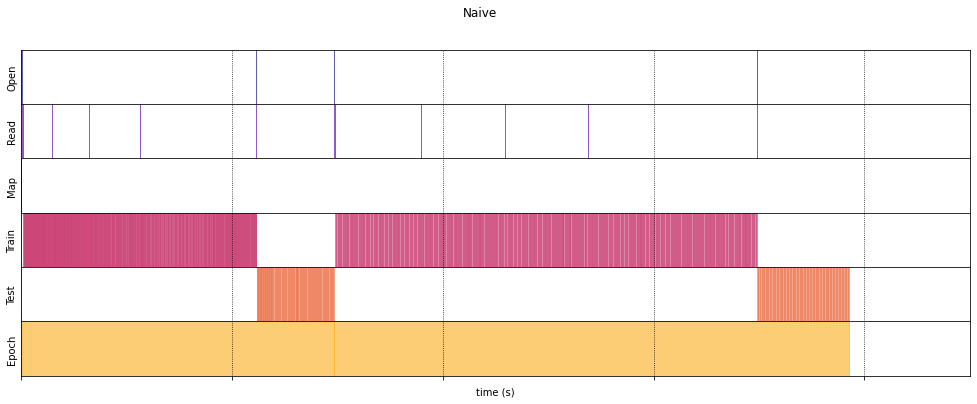

In [59]:
draw_timeline(timeline_Naive, "Naive", 900)

The dataset pipeline of `(dataset_train, dataset_test)` is same to the [CNN Model for CIFAR 10](#CNN-Model-for-CIFAR-10) part. However, if we optimize the pipeline as below, the performance would be better. The optimization is including:

1. [prefetching](https://www.tensorflow.org/guide/data_performance#prefetching): overlaps the preprocessing and model execution of a training step.
2. [Interleave (Parallelizing data extraction)](https://www.tensorflow.org/guide/data_performance#parallelizing_data_extraction): parallelize the data loading step, interleaving the contents of other datasets (such as data file readers).
3. [Parallel mapping](https://www.tensorflow.org/guide/data_performance#parallelizing_data_transformation): parallelized mapping across multiple CPU cores.
4. [Caching](https://www.tensorflow.org/guide/data_performance#caching): cache a dataset, save some operations (like file opening and data reading) from being executed during each epoch.
5. [Vectorizing mapping](https://www.tensorflow.org/guide/data_performance#vectorizing_mapping): batch before map, so that mapping can be vectorized.

It's recommended to study the terms above in the official documentation. Here we only demonstrate the timprovement.

In [60]:
# redefine map functions for recalculation of mapping time
IMAGE_SIZE_CROPPED = 24
IMAGE_HEIGHT = 32
IMAGE_WIDTH = 32
IMAGE_DEPTH = 3

# feel free to modify these two Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 64

# read data
def unpickle(file):
    with open(file, 'rb') as fo:
        raw_data = pickle.load(fo, encoding='bytes')
    return raw_data[b'data'],raw_data[b'labels']

# parse training data
@tf.function
def map_fun(steps, times, values, image, label):
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[tf.shape(image)[0], IMAGE_DEPTH, IMAGE_HEIGHT, IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    distorted_image = tf.image.random_crop(image, [tf.shape(image)[0], IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
    distorted_image = tf.image.random_flip_left_right(distorted_image)
    distorted_image = tf.image.random_brightness(distorted_image, max_delta=63)
    distorted_image = tf.image.random_contrast(distorted_image, lower=0.2, upper=1.8)
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter

    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

# parse testing data
def map_fun_test(steps, times, values, image, label):
    map_enter = time.perf_counter()
    
    image = tf.reshape(image,[tf.shape(image)[0],IMAGE_DEPTH,IMAGE_HEIGHT,IMAGE_WIDTH])
    image = tf.divide(tf.cast(tf.transpose(image,[0, 2, 3, 1]),tf.float32),255.0)
    distorted_image = tf.image.random_crop(image, [tf.shape(image)[0], IMAGE_SIZE_CROPPED,IMAGE_SIZE_CROPPED,3])
    distorted_image = tf.image.per_image_standardization(distorted_image)
    
    map_elapsed = time.perf_counter() - map_enter
    
    return tf.concat((steps, tf.tile([[["Map"]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((times, tf.tile([[[map_enter, map_elapsed]]], [BATCH_SIZE, 1, 1])), axis=1),\
           tf.concat((values, tf.tile([[values[:][-1][0]]], [BATCH_SIZE, 1, 1])), axis=1),\
           distorted_image,\
           label

In [61]:
dataset_train_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_train, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .shuffle(BUFFER_SIZE)\
                                                  .batch(BATCH_SIZE, drop_remainder=True)\
                                                  .map(map_fun, num_parallel_calls=tf.data.AUTOTUNE)\
                                                  .cache()\
                                                  .prefetch(tf.data.AUTOTUNE)
dataset_test_optimized = tf.data.Dataset.range(1).interleave(dataset_generator_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .batch(BATCH_SIZE, drop_remainder=True)\
                                                 .map(map_fun_test, num_parallel_calls=tf.data.AUTOTUNE)\
                                                 .cache()\
                                                 .prefetch(tf.data.AUTOTUNE)

In [62]:
# load the same initialization of weights and re-train with optimized input pipeline
model_cifar_op.load_weights('model_cifar_op.h5')
timeline_Optimized = timelined_benchmark(dataset_train_optimized, dataset_test_optimized)

training:


100%|█████████████████████████████████████████| 781/781 [03:30<00:00,  3.71it/s]

testing:



100%|█████████████████████████████████████████| 156/156 [01:10<00:00,  2.21it/s]

Epoch 1, Loss: 1.9224, Accuracy: 30.7078, test Loss: 1.5473, test Accuracy: 43.5797
training:



100%|█████████████████████████████████████████| 781/781 [06:11<00:00,  2.10it/s]

testing:



100%|█████████████████████████████████████████| 156/156 [01:18<00:00,  1.98it/s]

Epoch 2, Loss: 1.5598, Accuracy: 44.0621, test Loss: 1.3066, test Accuracy: 53.7961
Execution time: 731.6399118240224


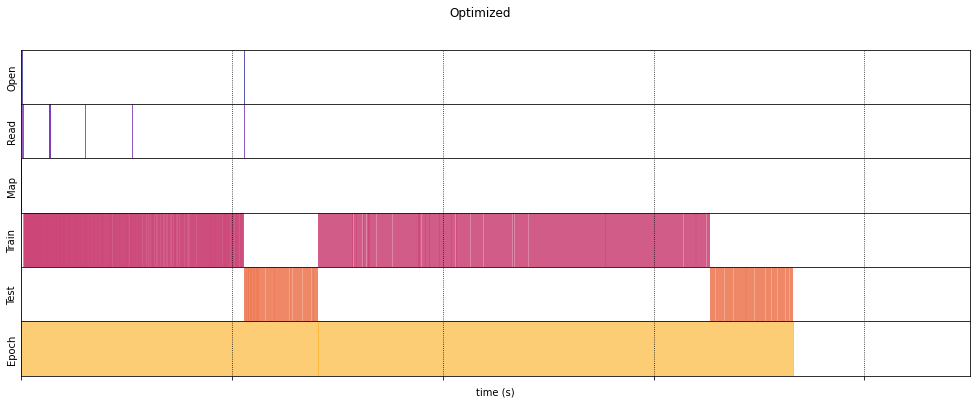

In [63]:
draw_timeline(timeline_Optimized, "Optimized", 900)

From the results above, we can find that the time comsuming reduces from 785 to 731 (sec).

It seems that there's not much imporvement of time comsuming. Even though there's exactly no "Open" and "Read" time consuming in 2nd epoch in the graph above (which is because of the Caching), **the bottleneck here is the training steps**, rather than I/O. Since we read images from `.pkl` files, which is an binary file with faster I/O speed, the loading of reading and mapping is much smaller than training steps. However, if we switch the situation like reading images from `.jpg`/`.png` files (what you would do in the assignment below), the imporvement would be evident.

# <center>Assignment</center>
In this assignment, you have to implement the input pipeline of the CNN model and try to write/read tfrecord with the **Oregon Wildlife** dataset.

We provide you with the complete code for the image classification task of the CNN model, but remove the part of the input pipeline. What you need to do is completing this part and training the model for at least 5 epochs.

### Description of Dataset:
1. The raw data is from [kaggle](https://www.kaggle.com/virtualdvid/oregon-wildlife), which consists of 20 class images of wildlife.
2. We have filtered the raw data. You need to download the filtered images from [here](https://drive.google.com/file/d/1HncttRdMHeNjde8xQCjQQtTLG8dcaTJx/view?usp=sharing) and use them to complete the image classification task.
3. In the dataset we prepared for you, there are nearly 7,200 images, which contain **10 kinds** of wildlife.

The sample image is shown below:

<center><img style='width: 50%, height=50%' height="350" width="350" src='./imgsrc/red_fox.png' /></center>
<center> red_fox </center>

### Requirement:

- Try some the input transfromation mentioned above (e.g. shuffle, batch, repeat, map(random_crop, random_flip_left_right, ...)) but without optimization terms (e.g. prefetch, cache, num_parallel_calls), comparing the performance to the no  input transfromation.
- Retrain your model with optimized terms, compare the time consuming.
- Training both models above for at least 3 epochs.
- Briefly summarize what you did and explain the performance results (accuracy and time consuming).

### Notification:
+ Submit to **eeclass** with your ipynb (Lab11-1_{student_id}.ipynb)
+ Deadline: 2022-11-6 (Sun) 23:59

In [64]:
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 

import tensorflow as tf
from tensorflow.keras import utils, datasets, layers, models
from tensorflow.keras.applications.vgg16 import VGG16
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import IPython.display as display
import matplotlib.pyplot as plt
import pathlib
import random
import numpy as np
import matplotlib as mpl
import time

import csv
import pandas as pd
import math
from tqdm import tqdm

import itertools
from collections import defaultdict

In [65]:
# You need to download the prepared data and unzip the file in current path('./')
data_root = pathlib.Path('./oregon_wildlife')

# print the subfolders.
print('classes:')
for item in data_root.iterdir():
    print(item)
    
all_image_paths = list(data_root.glob('*/*'))
all_image_paths = [str(path) for path in all_image_paths]
all_image_paths = shuffle(all_image_paths, random_state=1)
all_image_paths = [path for path in all_image_paths if path[-3:] not in ('gif','bmp')]
image_count = len(all_image_paths)
print('\ntotal img num:', image_count)

classes:
oregon_wildlife/bald_eagle
oregon_wildlife/cougar
oregon_wildlife/deer
oregon_wildlife/nutria
oregon_wildlife/raccoon
oregon_wildlife/raven
oregon_wildlife/red_fox
oregon_wildlife/sea_lions
oregon_wildlife/virginia_opossum
oregon_wildlife/black_bear

total img num: 7168


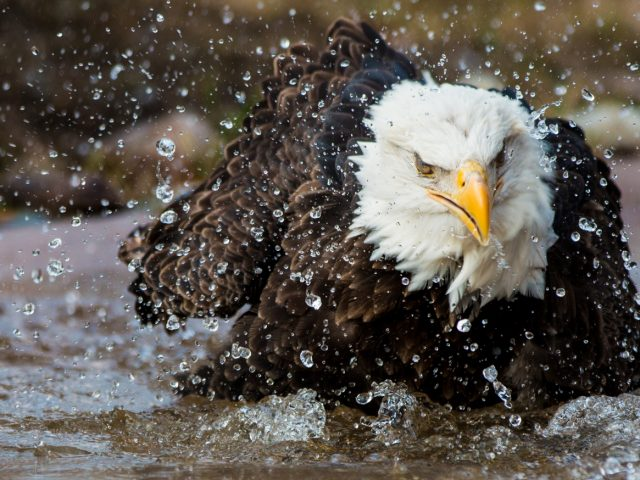

bald_eagle


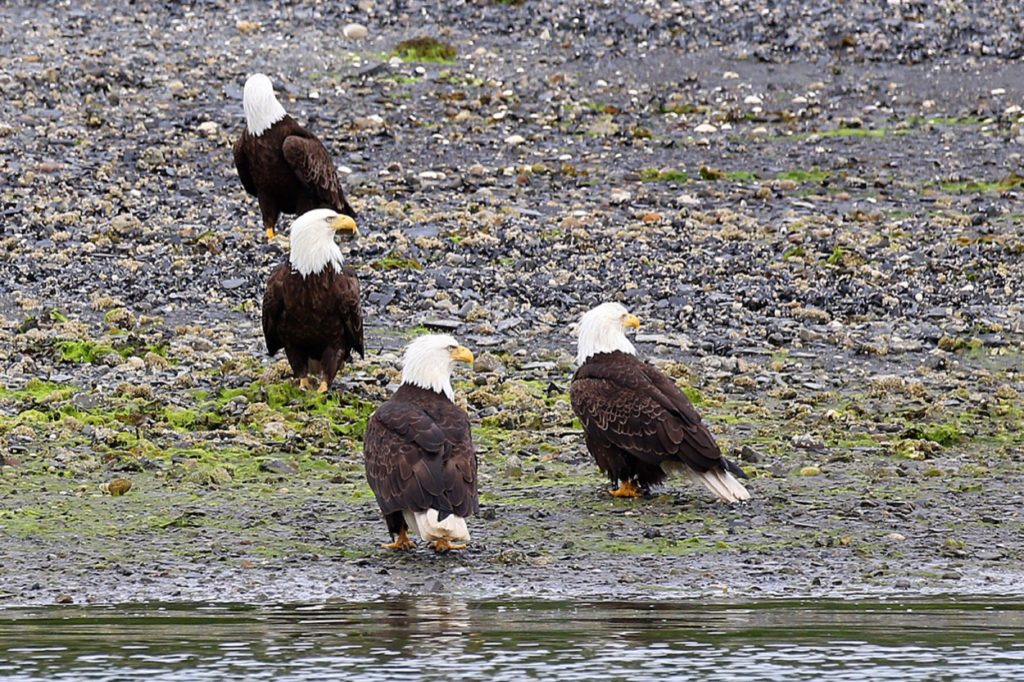

bald_eagle


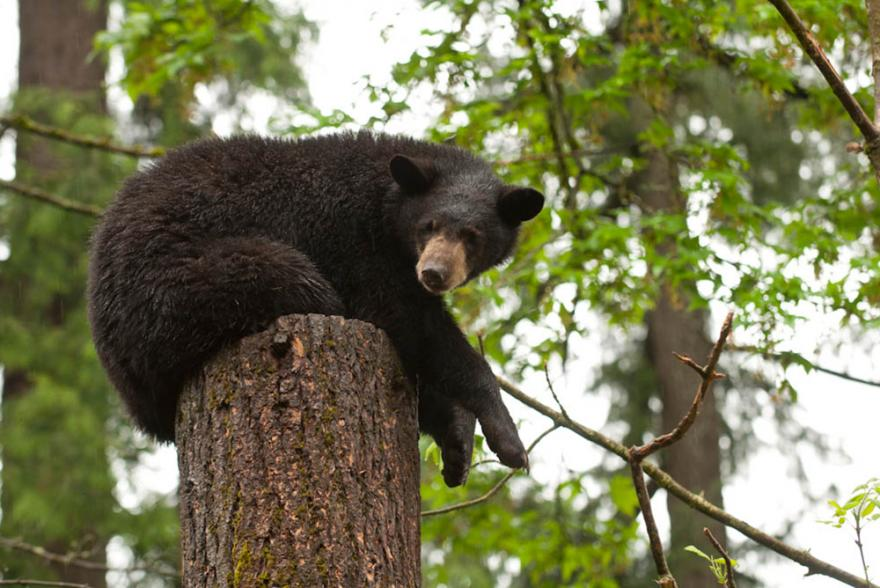

black_bear


In [66]:
# random showing 3 iamges for you
for n in range(3):
    image_path = random.choice(all_image_paths)
    display.display(display.Image(image_path, width=200, height=200))
    print(image_path.split('/')[-2])

In [67]:
# get the labels
label_names = sorted(item.name for item in data_root.glob('*/') if item.is_dir())
# total labels
n_classes = len(label_names)
print(label_names)

['bald_eagle', 'black_bear', 'cougar', 'deer', 'nutria', 'raccoon', 'raven', 'red_fox', 'sea_lions', 'virginia_opossum']


In [68]:
# get the mapping dict
label_to_index = dict((name, index) for index,name in enumerate(label_names))
index_to_label = dict((index, name) for index,name in enumerate(label_names))
print(label_to_index)

{'bald_eagle': 0, 'black_bear': 1, 'cougar': 2, 'deer': 3, 'nutria': 4, 'raccoon': 5, 'raven': 6, 'red_fox': 7, 'sea_lions': 8, 'virginia_opossum': 9}


In [69]:
# get the label data
all_image_labels = [label_to_index[pathlib.Path(path).parent.name] for path in all_image_paths]
print("First 10 labels indices: ", all_image_labels[:10])

First 10 labels indices:  [9, 6, 3, 6, 0, 3, 2, 0, 2, 0]


In [70]:
# Create training and validation sets using an 80-20 split
img_path_train, img_path_val, label_train, label_val = train_test_split(all_image_paths,
                                all_image_labels,test_size=0.2,random_state=0)
print('training data: %d'%(len(img_path_train)))
print('testing data: %d'%(len(img_path_val)))

training data: 5734
testing data: 1434


In [71]:
# save (img_path, label) pairs
with open('train.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_train, label_train):
        writer.writerow([img_path, label])
        
with open('val.csv', 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['img_path', 'label'])
    for img_path, label in zip(img_path_val, label_val):
        writer.writerow([img_path, label])

In [72]:
# You will use these setting in your code, pls do not modify these 4.
IMAGE_SIZE_CROPPED = 224
IMAGE_HEIGHT = 300
IMAGE_WIDTH = 300
IMAGE_DEPTH = 3

In [73]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=IMAGE_DEPTH)
    img = tf.image.resize(img, (IMAGE_HEIGHT, IMAGE_WIDTH))
    img = tf.cast(img, tf.float32)
    img = tf.divide(img,255.0)
    return img

In [74]:
class TimeMeasuredDataset(tf.data.Dataset):
    # OUTPUT: (steps, timings, counters, img, label)
    OUTPUT_SIGNATURE=(
        tf.TensorSpec(shape=(2, 1), dtype=tf.string),
        tf.TensorSpec(shape=(2, 2), dtype=tf.float32),
        tf.TensorSpec(shape=(2, 3), dtype=tf.int32),
        tf.TensorSpec(shape=(300,300,3), dtype=tf.float32),
        tf.TensorSpec(shape=(), dtype=tf.int32)
    )


    _INSTANCES_COUNTER = itertools.count()  # Number of datasets generated
    _EPOCHS_COUNTER = defaultdict(itertools.count)  # Number of epochs done for each dataset

    def _generator(instance_idx, filename):
        epoch_idx = next(TimeMeasuredDataset._EPOCHS_COUNTER[instance_idx])

        # Opening the file
        open_enter = time.perf_counter()
        
        rows = pd.read_csv(filename.decode("utf-8"))
        img_paths = rows['img_path'].tolist()
        labels = rows['label'].tolist()
        
        open_elapsed = time.perf_counter() - open_enter

        for sample_idx in range(len(img_paths)):
            # Reading data (line, record) from the file
            read_enter = time.perf_counter()
            img = load_image(img_paths[sample_idx])
            read_elapsed = time.perf_counter() - read_enter

            yield (
                [("Open",), ("Read",)],
                [(open_enter, open_elapsed), (read_enter, read_elapsed)],
                [(instance_idx, epoch_idx, -1), (instance_idx, epoch_idx, sample_idx)],
                img,
                labels[sample_idx]
            )
            open_enter, open_elapsed = -1., -1.  # Negative values will be filtered


    def __new__(cls, filename):
        return tf.data.Dataset.from_generator(
            cls._generator,
            output_signature=cls.OUTPUT_SIGNATURE,
            args=(next(cls._INSTANCES_COUNTER), filename)
        )

In [86]:
# feel free to modify these two Settings.
BUFFER_SIZE = 10000
BATCH_SIZE = 1

def dataset_generator_fun_train(*args):
    filename = 'train.csv'
    return TimeMeasuredDataset(filename)

def dataset_generator_fun_val(*args):
    return TimeMeasuredDataset('val.csv')

dataset_train = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_train).batch(BATCH_SIZE)
dataset_val = tf.data.Dataset.range(1).flat_map(dataset_generator_fun_val).batch(BATCH_SIZE)

tf.Tensor(
[[b'Open']
 [b'Read']], shape=(2, 1), dtype=string) tf.Tensor(
[[7.0958625e+05 1.2317144e-02]
 [7.0958625e+05 2.0169385e-02]], shape=(2, 2), dtype=float32) tf.Tensor(
[[ 2  0 -1]
 [ 2  0  0]], shape=(2, 3), dtype=int32)
(300, 300, 3)


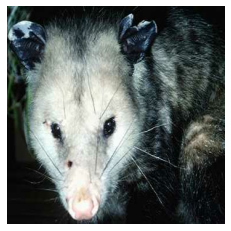

virginia_opossum


In [87]:
for steps, timings, counters, img, label in dataset_train.take(1):
    print(steps[0], timings[0], counters[0])
    print(img[0].shape)
    plt.imshow(img[0]) 
    plt.axis('off') 
    plt.show()
    print(index_to_label[label[0].numpy()])

In [88]:
base_model = VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(300, 300, 3),
    pooling=None,
)
for layer in base_model.layers:
    layer.trainable = False

top_model = models.Sequential()
top_model.add(layers.Flatten())
top_model.add(layers.Dense(4096, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(1024, activation='relu'))
top_model.add(layers.Dropout(0.5))
top_model.add(layers.Dense(n_classes, activation='softmax'))

wild_model = tf.keras.Model(inputs=base_model.input, outputs=top_model(base_model.output)) 

In [89]:
wild_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 300, 300, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 300, 300, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 300, 300, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 150, 150, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 150, 150, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 150, 150, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 75, 75, 128)       0   

In [90]:
# save the initialization of weights 
wild_model.save_weights('wild_model.h5')

In [91]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = tf.keras.optimizers.Adam()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

In [92]:
@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = wild_model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, wild_model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, wild_model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)
    
@tf.function
def val_step(images, labels):
    predictions = wild_model(images, training=False)
    v_loss = loss_object(labels, predictions)

    val_loss(v_loss)
    val_accuracy(labels, predictions)

In [93]:
def timelined_benchmark(dataset_train, dataset_test):
    EPOCHS = 3

    steps_acc = tf.zeros([0, 1], dtype=tf.dtypes.string)
    times_acc = tf.zeros([0, 2], dtype=tf.dtypes.float32)
    values_acc = tf.zeros([0, 3], dtype=tf.dtypes.int32)

    start_time = time.perf_counter()
    for epoch in range(EPOCHS):
        epoch_enter = time.perf_counter()
        # Reset the metrics at the start of the next epoch
        train_loss.reset_states()
        train_accuracy.reset_states()
        val_loss.reset_states()
        val_accuracy.reset_states()

        print("training:")
        for steps, times, values, images, labels in tqdm(dataset_train, total=math.ceil(len(img_path_train)/BATCH_SIZE)):
            for i in range(steps.shape[0]):
                steps_acc = tf.concat((steps_acc, steps[i]), axis=0)
                times_acc = tf.concat((times_acc, times[i]), axis=0)
                values_acc = tf.concat((values_acc, values[i]), axis=0)

            train_enter = time.perf_counter()
            train_step(images, labels)
            train_elapsed = time.perf_counter() - train_enter

            for i in range(steps.shape[0]):        
                steps_acc = tf.concat((steps_acc, [["Train"]]), axis=0)
                times_acc = tf.concat((times_acc, [(train_enter, train_elapsed)]), axis=0)
                values_acc = tf.concat((values_acc, [values[i,-1]]), axis=0)

        print("validating:")
        for steps, times, values, images, labels in tqdm(dataset_test, total=math.ceil(len(img_path_val)/BATCH_SIZE)):
            for i in range(steps.shape[0]):  
                steps_acc = tf.concat((steps_acc, steps[i]), axis=0)
                times_acc = tf.concat((times_acc, times[i]), axis=0)
                values_acc = tf.concat((values_acc, values[i]), axis=0)

            val_enter = time.perf_counter()
            val_step(images, labels)
            val_elapsed = time.perf_counter() - val_enter

            for i in range(steps.shape[0]):  
                steps_acc = tf.concat((steps_acc, [["Val"]]), axis=0)
                times_acc = tf.concat((times_acc, [(val_enter, val_elapsed)]), axis=0)
                values_acc = tf.concat((values_acc, [values[i,-1]]), axis=0)

        template = 'Epoch {:0}, Loss: {:.4f}, Accuracy: {:.4f}, val Loss: {:.4f}, val Accuracy: {:.4f}'
        print (template.format(epoch+1,
                               train_loss.result(),
                               train_accuracy.result()*100,
                               val_loss.result(),
                               val_accuracy.result()*100))

        epoch_elapsed = time.perf_counter() - epoch_enter
        steps_acc = tf.concat((steps_acc, [["Epoch"]]), axis=0)
        times_acc = tf.concat((times_acc, [(epoch_enter, epoch_elapsed)]), axis=0)
        values_acc = tf.concat((values_acc, [[-1, epoch, -1]]), axis=0)

    tf.print("Execution time:", time.perf_counter() - start_time)
    return {"steps": steps_acc, "times": times_acc, "values": values_acc}

In [94]:
def draw_timeline(timeline, title, width=0.5, annotate=False, save=False):
    # Remove invalid entries (negative times, or empty steps) from the timelines
    invalid_mask = np.logical_and(timeline['times'] > 0, timeline['steps'] != b'')[:,0]
    steps = timeline['steps'][invalid_mask].numpy()
    times = timeline['times'][invalid_mask].numpy()
    values = timeline['values'][invalid_mask].numpy()

    # Get a set of different steps, ordered by the first time they are encountered
    step_ids, indices = np.stack(np.unique(steps, return_index=True))
    step_ids = step_ids[np.argsort(indices)]

    # Shift the starting time to 0 and compute the maximal time value
    min_time = times[:,0].min()
    times[:,0] = (times[:,0] - min_time)
    end = max(width, (times[:,0]+times[:,1]).max() + 0.01)

    cmap = mpl.cm.get_cmap("plasma")
    plt.close()
    fig, axs = plt.subplots(len(step_ids), sharex=True, gridspec_kw={'hspace': 0})
    fig.suptitle(title)
    fig.set_size_inches(17.0, len(step_ids))
    plt.xlim(-0.01, end)

    order = [b'Open', b'Read', b'Map', b'Train', b'Val', b'Test', b'Epoch']
    step_ids = sorted(step_ids, key=lambda i: order.index(i))
    
    for i, step in enumerate(step_ids):
        step_name = step.decode()
        ax = axs[i]
        ax.set_ylabel(step_name)
        ax.set_ylim(0, 1)
        ax.set_yticks([])
        ax.set_xlabel("time (s)")
        ax.set_xticklabels([])
        ax.grid(which="both", axis="x", color="k", linestyle=":")

        # Get timings and annotation for the given step
        entries_mask = np.squeeze(steps==step)
        serie = np.unique(times[entries_mask], axis=0)
        annotations = values[entries_mask]

        ax.broken_barh(serie, (0, 1), color=cmap(i / len(step_ids)), linewidth=1, alpha=0.66)
        if annotate:
            for j, (start, width) in enumerate(serie):
                annotation = "\n".join([f"{l}: {v}" for l,v in zip(("i", "e", "s"), annotations[j])])
                ax.text(start + 0.001 + (0.001 * (j % 2)), 0.55 - (0.1 * (j % 2)), annotation,
                        horizontalalignment='left', verticalalignment='center')
    if save:
        plt.savefig(title.lower().translate(str.maketrans(" ", "_")) + ".svg")

In [95]:
timeline_Naive = timelined_benchmark(dataset_train, dataset_val)

training:


100%|███████████████████████████████████████| 5734/5734 [04:51<00:00, 19.68it/s]


validating:


100%|███████████████████████████████████████| 1434/1434 [00:52<00:00, 27.22it/s]


Epoch 1, Loss: 4.7885, Accuracy: 11.2487, val Loss: 2.3116, val Accuracy: 11.0181
training:


100%|███████████████████████████████████████| 5734/5734 [04:56<00:00, 19.37it/s]


validating:


100%|███████████████████████████████████████| 1434/1434 [00:53<00:00, 26.80it/s]


Epoch 2, Loss: 2.8123, Accuracy: 9.7140, val Loss: 2.2959, val Accuracy: 10.1813
training:


100%|███████████████████████████████████████| 5734/5734 [04:58<00:00, 19.22it/s]


validating:


100%|███████████████████████████████████████| 1434/1434 [00:54<00:00, 26.50it/s]


Epoch 3, Loss: 2.4784, Accuracy: 9.9756, val Loss: 2.2980, val Accuracy: 11.8550
Execution time: 1046.1144039030187


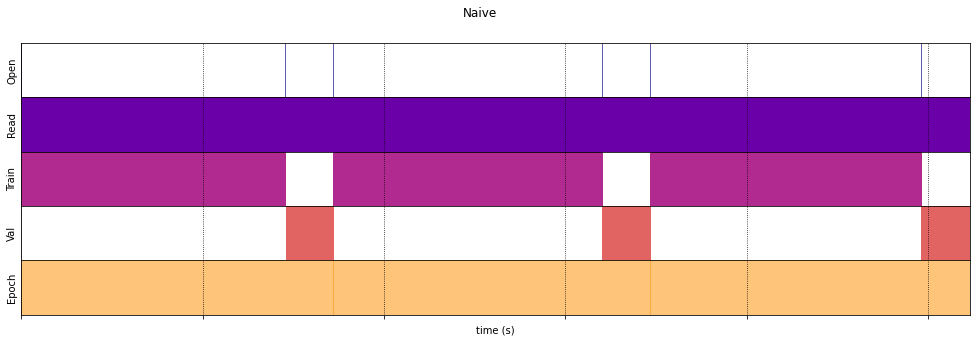

In [96]:
draw_timeline(timeline_Naive, "Naive", 500)

The accuracy now is 11.85% in validation set, costing with 1046 sec. Now try some data augmentation (transformation) to observe whether the accuracy and execution time are increased or decreased.

In [ ]:
## TODO: build `dataset_train_augmentation` and `dataset_test_augmentation` with transformation
## Remember to define your own map functions before calling map

# dataset_train_augmentation = tf.data.Dataset.range(1). ...
# dataset_train_augmentation = tf.data.Dataset.range(1). ...

In [ ]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Augmentation = timelined_benchmark(dataset_train_augmentation, dataset_test_augmentation)

In [ ]:
draw_timeline(timeline_Augmentation, "Augmentation", 500)

After trying data augmentation (transformation), it's time to optimize what you did above for better efficiency.

In [ ]:
## TODO: build `dataset_train_optimized` and `dataset_test_optimized` with transformation and optimzation
## Remember to re-define your own map functions again to make mapping time re-calculated

# dataset_train_optimized = tf.data.Dataset.range(1). ...
# dataset_test_optimized = tf.data.Dataset.range(1). ...

In [ ]:
# load the same initialization of weights and re-train with optimized input pipeline
wild_model.load_weights('wild_model.h5')
timeline_Optimized = timelined_benchmark(dataset_train_optimized, dataset_test_optimized)

In [ ]:
draw_timeline(timeline_Optimized, "Optimized", 500)